In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imutils
import cv2
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras import backend as K

In [5]:
# import the necessary packages

def LeNet(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
    
        # return the constructed network architecture
        return model

In [261]:
data = []
labels = []

for imagePath in sorted(list(paths.list_images("smiles"))):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width=28)
    image = img_to_array(image)
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-3]
    label = "smiling" if label == "positives" else "not_smiling"
    labels.append(label)

In [262]:
data = np.array(data, dtype='float')/255.0
labels = np.array(labels)

le = LabelEncoder()
labels = le.fit_transform(labels)

In [263]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', np.unique(labels, axis=0), labels)
weights = {i : weights[i] for i in range(2)}

min_ = min(weights[0], weights[1])

for i in range(len(weights)):
    weights[i] = weights[i]/min_

In [264]:
labels = to_categorical(labels, 2)

In [265]:
# classTotals = labels.sum(axis=0)
# classWeight = classTotals.max() / classTotals

In [266]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [267]:
model = LeNet(width=28, height=28, depth=1, classes=2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [269]:
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), class_weight=weights, batch_size=64, epochs=15, verbose=1)

Epoch 1/15
165/165 [==============================] - 4s 20ms/step - loss: 0.8845 - accuracy: 0.6311 - val_loss: 0.3260 - val_accuracy: 0.8618
Epoch 2/15
165/165 [==============================] - 3s 21ms/step - loss: 0.5074 - accuracy: 0.8478 - val_loss: 0.4211 - val_accuracy: 0.8147
Epoch 3/15
165/165 [==============================] - 3s 19ms/step - loss: 0.4370 - accuracy: 0.8719 - val_loss: 0.2716 - val_accuracy: 0.8959
Epoch 4/15
165/165 [==============================] - 3s 20ms/step - loss: 0.3998 - accuracy: 0.8872 - val_loss: 0.3025 - val_accuracy: 0.8743
Epoch 5/15
165/165 [==============================] - 3s 20ms/step - loss: 0.3886 - accuracy: 0.8962 - val_loss: 0.2657 - val_accuracy: 0.8906
Epoch 6/15
165/165 [==============================] - 3s 20ms/step - loss: 0.3720 - accuracy: 0.9008 - val_loss: 0.3440 - val_accuracy: 0.8485
Epoch 7/15
165/165 [==============================] - 3s 20ms/step - loss: 0.3516 - accuracy: 0.8991 - val_loss: 0.3001 - val_accuracy: 0.8705

In [270]:
predictions = model.predict(X_test, batch_size=64)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))
# save the model to disk

model.save("face_detection.hdf5")

              precision    recall  f1-score   support

 not_smiling       0.95      0.93      0.94      1895
     smiling       0.82      0.88      0.85       738

    accuracy                           0.91      2633
   macro avg       0.89      0.90      0.89      2633
weighted avg       0.92      0.91      0.91      2633



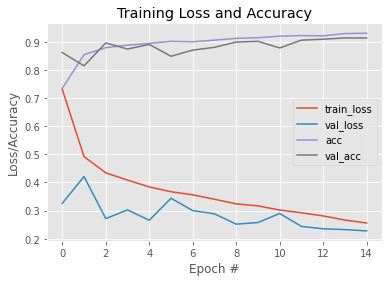

In [271]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()